In [1]:
import argparse
import os
import torch
from exp.exp_long_term_forecasting import Exp_Long_Term_Forecast
from exp.exp_imputation import Exp_Imputation
from exp.exp_short_term_forecasting import Exp_Short_Term_Forecast
from exp.exp_anomaly_detection import Exp_Anomaly_Detection
from exp.exp_classification import Exp_Classification
from utils.print_args import print_args
import random
import numpy as np

from data_provider.data_factory import data_provider
from exp.exp_basic import Exp_Basic
from utils.tools import EarlyStopping, adjust_learning_rate, visual
from utils.metrics import metric
import torch
import torch.nn as nn
from torch import optim
import os
import time
import warnings
import numpy as np

/root/anaconda3/envs/TSlib/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import argparse

# 创建一个类似命令行参数对象的实例
args = argparse.Namespace()

# 设置参数的默认值
args.task_name = 'long_term_forecast'
args.is_training = 1
args.model_id = 'test'
args.model = 'PatchTST'
args.data = 'FaaS'
args.root_path = './dataset/FaaS/'
args.data_path = 'data_sample.csv'
args.features = 'M'
args.target = 'OT'
args.freq = 'h'
args.checkpoints = './checkpoints/'
args.seq_len = 1440
args.label_len = 720
args.pred_len = 60
args.seasonal_patterns = 'Monthly'
args.inverse = False
args.mask_rate = 0.25
args.anomaly_ratio = 0.25
args.expand = 2
args.d_conv = 4
args.top_k = 5
args.num_kernels = 6
args.enc_in = 7
args.dec_in = 7
args.c_out = 7
args.d_model = 512
args.n_heads = 8
args.e_layers = 2
args.d_layers = 1
args.d_ff = 2048
args.moving_avg = 25
args.factor = 3
args.distil = True
args.dropout = 0.1
args.embed = 'timeF'
args.activation = 'gelu'
args.output_attention = False
args.channel_independence = 1
args.decomp_method = 'moving_avg'
args.use_norm = 1
args.down_sampling_layers = 0
args.down_sampling_window = 1
args.down_sampling_method = None
args.seg_len = 48
args.num_workers = 10
args.itr = 1
args.train_epochs = 10
args.batch_size = 32
args.patience = 3
args.learning_rate = 0.0001
args.des = 'Exp'
args.loss = 'MSE'
args.lradj = 'type1'
args.use_amp = False
args.use_gpu = False
args.gpu = 0
args.use_multi_gpu = False
args.devices = '0,1,2,3'
args.p_hidden_dims = [128, 128]
args.p_hidden_layers = 2

# 输出参数的值
print(args.task_name)
print(args.is_training)
# 其他参数...

# 使用 args 对象继续进行后续操作

setting = '{}_{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_expand{}_dc{}_fc{}_eb{}_dt{}_{}_{}'.format(
    'long_term_forecast',
    'FaaS_1440_60',
    'PatchTST',
    'FaaS',
    'S',
    1440,
    720,
    60,
    512,
    2,
    1,
    1,
    2048,
    2,
    4,
    3,
    'timeF',
    True,
    'Exp',
    0
)
if args.task_name == 'long_term_forecast':
    Exp = Exp_Long_Term_Forecast
elif args.task_name == 'short_term_forecast':
    Exp = Exp_Short_Term_Forecast
elif args.task_name == 'imputation':
    Exp = Exp_Imputation
elif args.task_name == 'anomaly_detection':
    Exp = Exp_Anomaly_Detection
elif args.task_name == 'classification':
    Exp = Exp_Classification
else:
    Exp = Exp_Long_Term_Forecast

exp = Exp(args)

long_term_forecast
1


NameError: name 'Exp_Long_Term_Forecast' is not defined

In [45]:
exp.model.load_state_dict(torch.load(os.path.join('./checkpoints/' + setting, 'checkpoint.pth'), map_location=torch.device('cpu')))

RuntimeError: Error(s) in loading state_dict for Model:
	Missing key(s) in state_dict: "encoder.attn_layers.1.attention.query_projection.weight", "encoder.attn_layers.1.attention.query_projection.bias", "encoder.attn_layers.1.attention.key_projection.weight", "encoder.attn_layers.1.attention.key_projection.bias", "encoder.attn_layers.1.attention.value_projection.weight", "encoder.attn_layers.1.attention.value_projection.bias", "encoder.attn_layers.1.attention.out_projection.weight", "encoder.attn_layers.1.attention.out_projection.bias", "encoder.attn_layers.1.conv1.weight", "encoder.attn_layers.1.conv1.bias", "encoder.attn_layers.1.conv2.weight", "encoder.attn_layers.1.conv2.bias", "encoder.attn_layers.1.norm1.weight", "encoder.attn_layers.1.norm1.bias", "encoder.attn_layers.1.norm2.weight", "encoder.attn_layers.1.norm2.bias". 

In [32]:
import matplotlib.pyplot as plt

def visual(true, preds=None, pred_fix=None, lower=None, upper=None, name='./pic/test.pdf', save_file=False):
    """
    Results visualization
    """
    plt.figure(figsize=(12.8, 4.8))
    plt.plot(true, label='GroundTruth', linewidth=2)
    if preds is not None:
        plt.plot(preds, label='Online', linewidth=2)
    if pred_fix is not None:
        plt.plot(pred_fix, label='DLinear_fix', linewidth=2)
    if lower is not None and upper is not None:
        x = np.arange(len(lower))
        upper = np.array(upper)
        lower = np.array(lower)
        plt.plot(upper, label='Upper_bound', linewidth=0.5)
        plt.plot(lower, label='Lower_bound', linewidth=0.5)
        plt.fill_between(x, upper, lower, where=(upper > lower) , facecolor='blue', alpha=0.3)
    plt.legend()
    if save_file:
        plt.savefig(name, bbox_inches='tight')

In [2]:
# import torch 
import numpy as np
# onenet_file = "/mnt/bn/jiadong2/Online_results/onenet_fsnet_FaaS_medium_1440_pl60_olfull_optadam_tb1_2024_07_08_21_45_1f34/"
mimo_file = "/mnt/bn/jiadong2/Online_results/mimo_patch_FaaS_small_1440_pl60_olfull_optadam_tb1_2024_07_23_23_15_13b9/"
mimo_file_without_online = "/mnt/bn/jiadong2/Online_results/mimo_patch_FaaS_small_1440_pl60_olfull_optadam_tb1_2024_07_23_23_09_5284/"
# mimo_greedy_file = "/mnt/bn/jiadong2/Online_results/mimo_patch_FaaS_small_1440_pl60_olfull_optadam_tb1_2024_07_09_16_46_91d2/"
preds = np.load(mimo_file + f"preds.npy")
trues = np.load(mimo_file + f"trues.npy")
mses = np.load(mimo_file + f"mse.npy")
mses_offline = np.load(mimo_file_without_online + f"mse.npy")
preds_offline = np.load(mimo_file_without_online + f"preds.npy")
# preds_onenet = np.load(mimo_greedy_file + f"preds.npy")
# pred_fixs = np.load(f'./test_results/pred_fix.npy')
preds_offline.shape,mses_offline.shape # preds_onenet.shape


((1, 168, 60, 7), (1, 168))

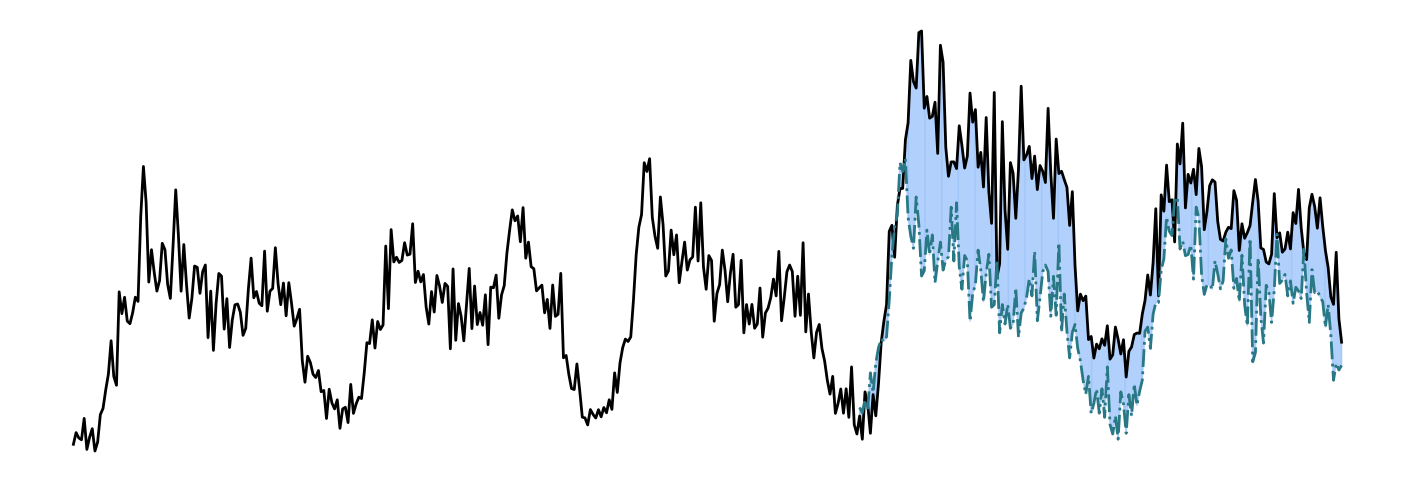

In [33]:
import numpy as np  
import matplotlib.pyplot as plt

  
def aggregate_by_mean(arr, n=5):  
    """  
    将数组中的每n个点进行均值聚合。  
      
    参数:  
    arr -- 输入的NumPy数组  
    n -- 每个聚合组的点数，默认为5  
      
    返回:  
    new_arr -- 聚合后的新数组  
    """  
    # 检查数组长度是否是n的倍数，如果不是，则截断数组  
    length = len(arr)  
    if length % n != 0:  
        arr = arr[:-(length % n)]  # 截断数组以使其成为n的倍数  
      
    # 使用reshape和mean进行聚合  
    new_arr = arr.reshape(-1, n).mean(axis=1)  
      
    return new_arr  

def aggregate_by_median(arr, n=5):  
    """  
    将数组中的每n个数进行中位数聚合。  
      
    参数:  
    arr -- 输入的NumPy数组  
    n -- 每个聚合组的点数，默认为5  
      
    返回:  
    new_arr -- 聚合后的新数组，包含每n个数的中位数  
    """  
    # 检查数组长度是否足够进行至少一个完整的聚合  
    if len(arr) < n:  
        raise ValueError("数组长度必须至少为n")  
      
    # 计算可以完整聚合的组数  
    groups = len(arr) // n  
      
    # 初始化结果数组  
    new_arr = np.empty(groups)  
      
    # 对每个组计算中位数  
    for i in range(groups):  
        start = i * n  
        end = start + n  
        group = arr[start:end]  
        # 由于n是5，我们直接取排序后的第三个数作为中位数  
        new_arr[i] = np.sort(group)[n // 2]  
      
    return new_arr
  

# preds_1d = preds[0,:,:,3].reshape(-1)
# preds_offline_1d = preds_offline[0,:,:,3].reshape(-1)

trues_1d = trues[0,:,:,1].reshape(-1)
aggre_trues_1d = aggregate_by_median(trues_1d, n=15)
# aggre_preds_offline_1d = aggregate_by_median(preds_offline_1d, n=5)
# aggre_preds_1d = aggregate_by_median(preds_1d, n=5)
# test = aggre_trues_1d[100:280]
# new_arr = np.concatenate((test, aggre_trues_1d[100:]))
# # new_arr = np.concatenate((new_arr, new_arr))
# new_arr = np.concatenate((new_arr, new_arr[:48]))

# aggre_trues_1d = np.concatenate((aggre_trues_1d[:380], aggre_trues_1d[380:]-1))

# test = aggre_trues_1d[100:280]
# new_arr = np.concatenate((test, aggre_trues_1d[100:]))
plt.figure(figsize=(18, 6))


y_1 = aggre_trues_1d[100:1000]
test = aggre_trues_1d[100:280]
new_arr = np.concatenate((test, aggre_trues_1d[100:]))
y_2 = new_arr[:900]



# x = np.arange(len(y_1))

# print(y_1.shape, y_2.shape)


# test = aggre_trues_1d[-1500-580:-580]
# new_arr = np.concatenate((test, test[-580:]))
# y_1 = aggre_trues_1d[-1500:]
# y_2 = new_arr[-1500-290:-290]



y_1 = np.concatenate((aggre_trues_1d[100:400], (aggre_trues_1d[400:-200]+1)*1.5))
y_1 = np.concatenate((y_1, aggre_trues_1d[-200:-100]+1))
# y_1 = aggre_trues_1d[100:-100]
y_2 = np.concatenate((y_1[:-180], aggre_trues_1d[5:-195][-180:]))

# plt.plot(aggre_trues_1d[200:], label='GroundTruth', linewidth=2, color='black')
# plt.plot(y_2, label='w/o Online Setting', linestyle='--', linewidth=2, color='#287885')

# plt.plot(aggre_preds_1d[-1700:-400], label='MIMO-EGD', linewidth=2, color='#C82423')
# plt.plot(aggre_trues_1d[-1500-290:-290], label='w/o Online Setting', linestyle='--', linewidth=2, color='#287885')
# plt.plot(trues_1d[:], label='GroundTruth', linewidth=2, color='black')
# plt.plot(preds_1d[:2000], label='MIMO-EGD', linewidth=2, color='#C82423')
# plt.plot(preds_offline_1d[:4000], label='w/o Online Setting', linestyle='--', linewidth=2, color='#287885')
x = np.arange(len(y_1))
plt.plot(y_1, label='GroundTruth', linewidth=2, color='black')
plt.plot(x[-180:], y_2[-180:], label='Offline Forecasting', linestyle='-.', linewidth=2, color='#287885')
plt.fill_between(x[-180:], y_1[-180:], y_2[-180:], where=(y_1[-180:] > y_2[-180:]), interpolate=True, color='#9EC5FA', alpha=0.8, hatch='|', label='Difference Area')
plt.fill_between(x[-180:], y_1[-180:], y_2[-180:], where=(y_1[-180:] < y_2[-180:]), interpolate=True, color='#9EC5FA', alpha=0.8, hatch='|', label='Difference Area')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

# plt.legend()
# plt.savefig('./figures/fix_9100.pdf', format='pdf')  # 将图表保存为PDF格式，‌文件名为example_plot.pdf
plt.savefig(f'./figures/background_3_median8_100.svg', format='svg', bbox_inches='tight', transparent=True)
# plt.savefig(f'./figures/background_0_median5_-1500.svg', format='svg', bbox_inches='tight', transparent=True)
# plt.savefig(f'./figures/background_1_median15_100.svg', format='svg', bbox_inches='tight', transparent=True)
plt.show()


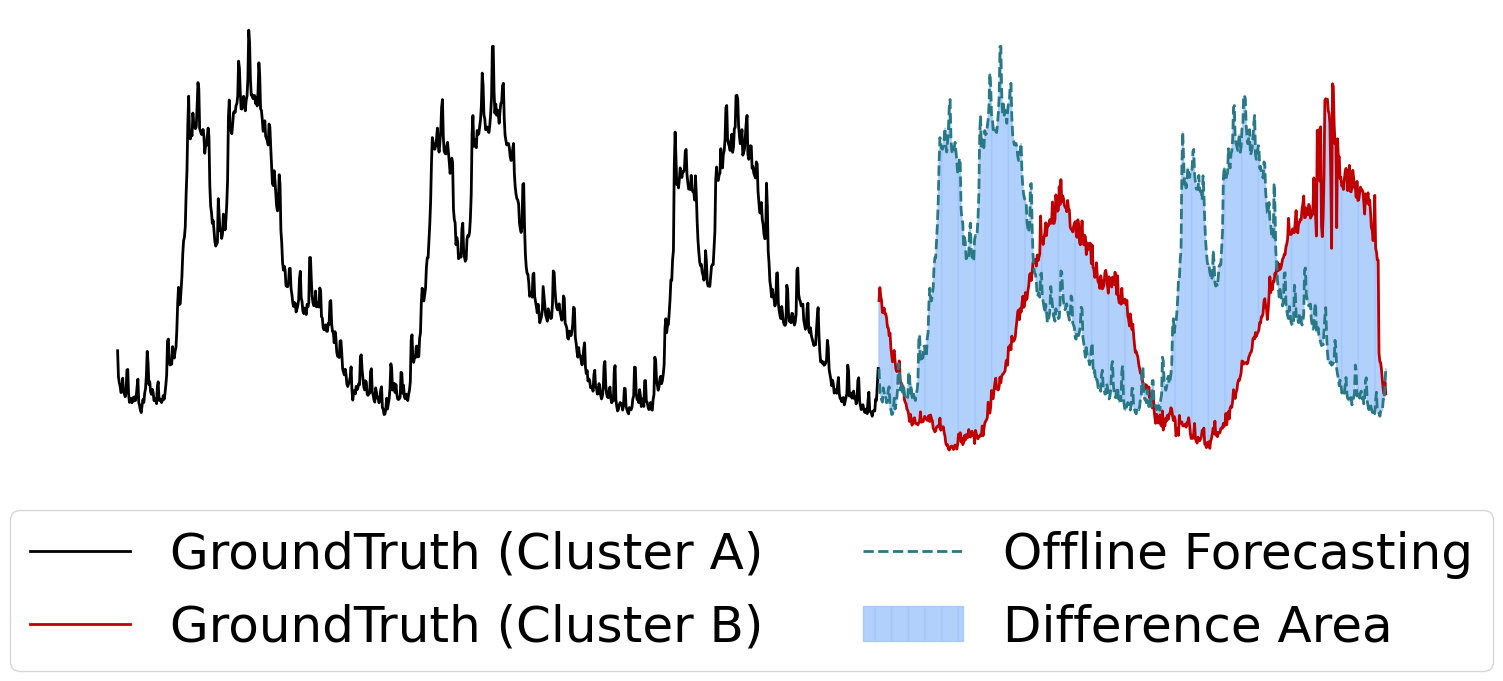

In [3]:
import numpy as np  
import matplotlib.pyplot as plt

  
def aggregate_by_mean(arr, n=5):  
    """  
    将数组中的每n个点进行均值聚合。  
      
    参数:  
    arr -- 输入的NumPy数组  
    n -- 每个聚合组的点数，默认为5  
      
    返回:  
    new_arr -- 聚合后的新数组  
    """  
    # 检查数组长度是否是n的倍数，如果不是，则截断数组  
    length = len(arr)  
    if length % n != 0:  
        arr = arr[:-(length % n)]  # 截断数组以使其成为n的倍数  
      
    # 使用reshape和mean进行聚合  
    new_arr = arr.reshape(-1, n).mean(axis=1)  
      
    return new_arr  

def aggregate_by_median(arr, n=5):  
    """  
    将数组中的每n个数进行中位数聚合。  
      
    参数:  
    arr -- 输入的NumPy数组  
    n -- 每个聚合组的点数，默认为5  
      
    返回:  
    new_arr -- 聚合后的新数组，包含每n个数的中位数  
    """  
    # 检查数组长度是否足够进行至少一个完整的聚合  
    if len(arr) < n:  
        raise ValueError("数组长度必须至少为n")  
      
    # 计算可以完整聚合的组数  
    groups = len(arr) // n  
      
    # 初始化结果数组  
    new_arr = np.empty(groups)  
      
    # 对每个组计算中位数  
    for i in range(groups):  
        start = i * n  
        end = start + n  
        group = arr[start:end]  
        # 由于n是5，我们直接取排序后的第三个数作为中位数  
        new_arr[i] = np.sort(group)[n // 2]  
      
    return new_arr
  

# preds_1d = preds[0,:,:,3].reshape(-1)
# preds_offline_1d = preds_offline[0,:,:,3].reshape(-1)

trues_1d = trues[0,:,:,0].reshape(-1)
aggre_trues_1d = aggregate_by_median(trues_1d, n=5)

trues_1d_2 = trues[0,:,:,2].reshape(-1)
aggre_trues_1d_2 = aggregate_by_median(trues_1d_2, n=5)

plt.figure(figsize=(18, 6))




# x = np.arange(len(y_1))

# print(y_1.shape, y_2.shape)

y_1 = aggre_trues_1d
y_2 = aggre_trues_1d_2

x = np.arange(100000)
plt.plot(x[500:1400], y_1[-1500:-600], label='GroundTruth (Cluster A)', linewidth=2, color='black')
line,  = plt.plot(x[1400:2000], y_2[1400:2000], label='GroundTruth (Cluster B)' ,linestyle='-', linewidth=2, color='#C00000')
# dash_sequence = [10]  
# line.set_dashes(dash_sequence)  
plt.plot(x[1400:2000], y_1[-1200:-600], label='Offline Forecasting', linestyle='--', linewidth=2, color='#287885')

# plt.plot(x[-600:], y_2[-600:], label='Offline Forecasting', linestyle='-.', linewidth=2, color='#287885')
plt.fill_between(x[1400:2000], y_1[-1200:-600], y_2[1400:2000], where=(y_1[-1200:-600] > y_2[1400:2000]), interpolate=True, color='#9EC5FA', alpha=0.8, hatch='|', )
plt.fill_between(x[1400:2000], y_1[-1200:-600], y_2[1400:2000], where=(y_1[-1200:-600] < y_2[1400:2000]), interpolate=True, color='#9EC5FA', alpha=0.8, hatch='|', label='Difference Area')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

# plt.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.03), fontsize=24)

plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.03), fontsize=36)

plt.savefig(f'./figures/background_transfer.svg', format='svg', bbox_inches='tight', transparent=True)

plt.show()

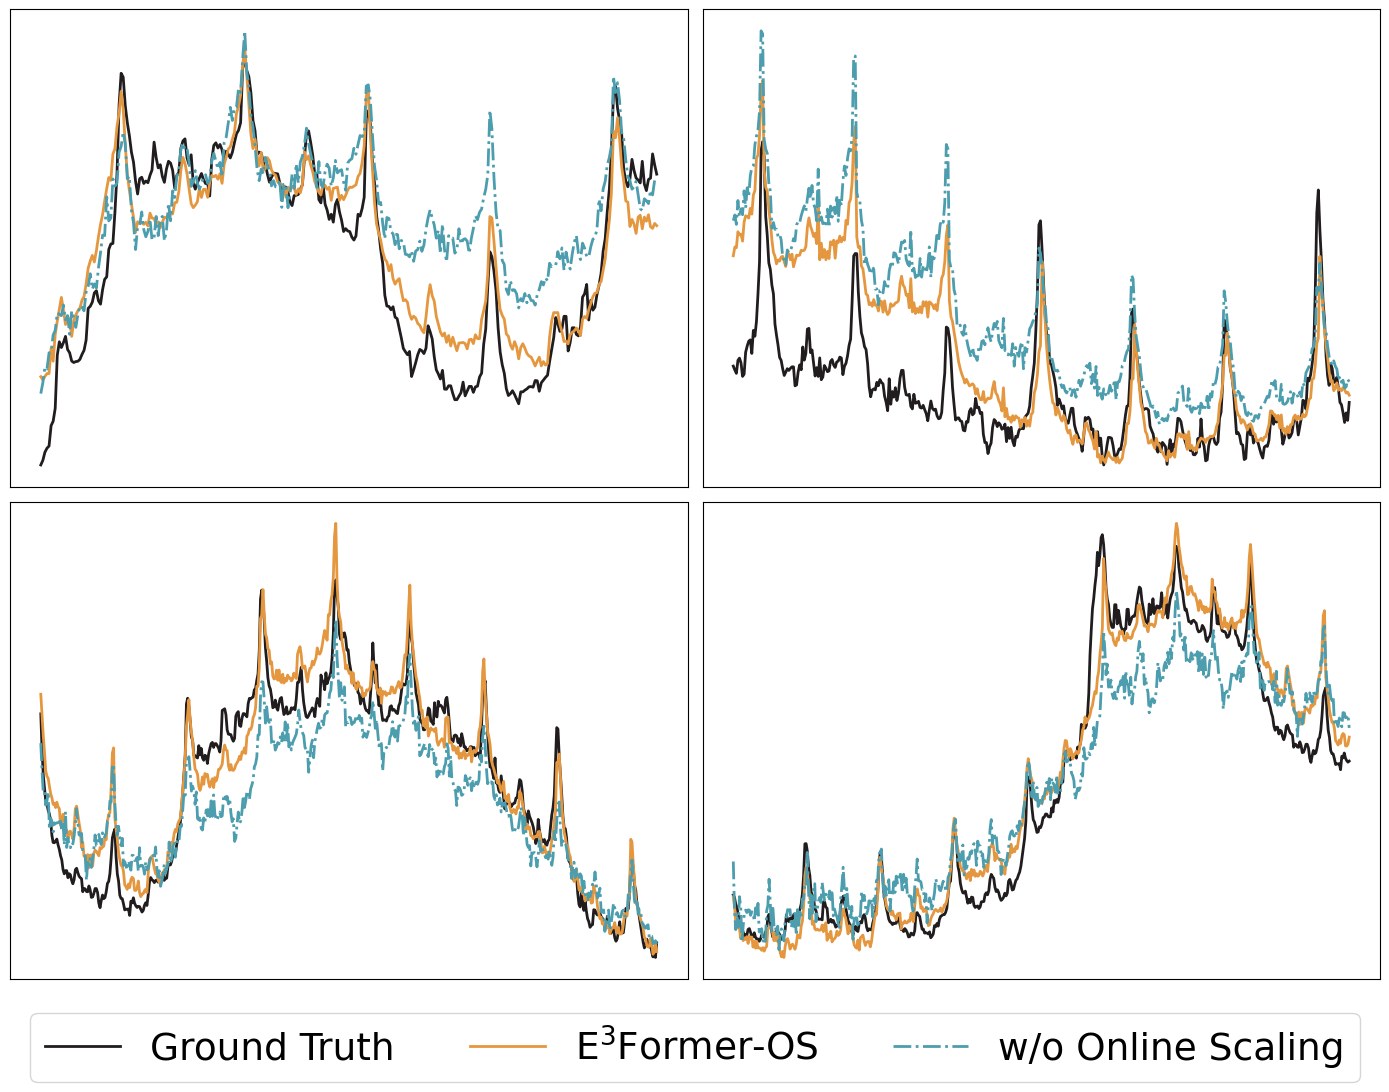

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 假设有四组数据
trues_1d = trues[0,:,:,0].reshape(-1)
preds_1d = preds[0,:,:,0].reshape(-1)
preds_offline_1d = preds_offline[0,:,:,0].reshape(-1)
# aggre_trues_1d = aggregate_by_median(trues_1d, n=5)

trues_1 = trues_1d[-2800:-2500]
preds_1 = preds_1d[-2800:-2500]
preds_offline_1 = preds_offline_1d[-2800:-2500]
trues_4 = trues_1d[-4500:-4000]
preds_4 = preds_1d[-4500:-4000]
preds_offline_4 = preds_offline_1d[-4500:-4000]
trues_3 = trues_1d[6000:6500]
preds_3 = preds_1d[6000:6500]
preds_offline_3 = preds_offline_1d[6000:6500]
trues_2 = trues_1d[9100:9500]
preds_2 = preds_1d[9100:9500]
preds_offline_2 = preds_offline_1d[9100:9500]

# 创建一个2x2的子图布局
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# 绘制第一张图
color_groundtrhth = '#211D1F'
color_mimo = '#E5973F'
color_offline = '#4C9DAE'
label_mimo='E$^3$Former-OS'
linewidth =2 
axs[0, 0].plot(trues_1, label='Ground Truth', color=color_groundtrhth, linewidth=linewidth)
axs[0, 0].plot(preds_1, label=label_mimo, color=color_mimo, linewidth=linewidth)
axs[0, 0].plot(preds_offline_1, label='w/o Online Scaling', linestyle='-.', color=color_offline, linewidth=linewidth)

# axs[0, 0].set_title('Plot 1')
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])

# 绘制第二张图
# axs[0, 1].plot(data2, label='Data 2', linestyle='--')
axs[0, 1].plot(trues_2, label='Ground Truth', color=color_groundtrhth, linewidth=linewidth)
axs[0, 1].plot(preds_2, label=label_mimo, color=color_mimo, linewidth=linewidth)
axs[0, 1].plot(preds_offline_2, label='w/o Online Scaling', linestyle='-.', color=color_offline, linewidth=linewidth)
# axs[0, 1].set_title('Plot 2')
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])

# 绘制第三张图
# axs[1, 0].plot(data3, label='Data 3', marker='o')
axs[1,0].plot(trues_3, label='Ground Truth', color=color_groundtrhth, linewidth=linewidth)
axs[1,0].plot(preds_3, label=label_mimo, color=color_mimo, linewidth=linewidth)
axs[1,0].plot(preds_offline_3, label='w/o Online Scaling', linestyle='-.', color=color_offline, linewidth=linewidth)
# axs[1, 0].set_title('Plot 3')
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

# 绘制第四张图
# axs[1, 1].plot(data4, label='Data 4', color='r', linestyle='--')
axs[1,1].plot(trues_4, label='Ground Truth', color=color_groundtrhth, linewidth=linewidth)
axs[1,1].plot(preds_4, label=label_mimo, color=color_mimo, linewidth=linewidth)
axs[1,1].plot(preds_offline_4, label='w/o Online Scaling', linestyle='-.', color=color_offline, linewidth=linewidth)
# axs[1, 1].set_title('Plot 4')
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])

# 共享图例
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0), fontsize=27)

# 调整子图间距
plt.tight_layout()


# 保存图表
plt.savefig('./figures/fix_test.pdf', format='pdf', bbox_inches='tight')

# 显示图表
plt.show()


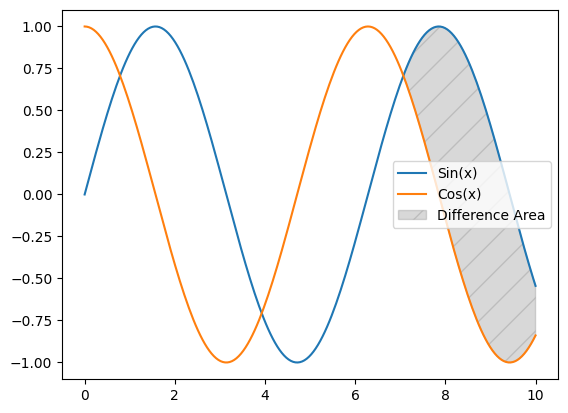

In [149]:
import numpy as np
import matplotlib.pyplot as plt

# 生成示例数据
x = np.linspace(0, 10, 200)  # 200个点的x值
y1 = np.sin(x)  # 第一条折线的y值
y2 = np.cos(x)  # 第二条折线的y值

# 绘制两条折线
plt.plot(x, y1, label='Sin(x)')
plt.plot(x, y2, label='Cos(x)')

# 仅标记第100个点之后两条折线的差值区域
# 假设我们起始标记的索引为100（注意Python索引从0开始）
start_index = 100
plt.fill_between(x[start_index:], y1[start_index:], y2[start_index:], where=(y1[start_index:] >= y2[start_index:]), interpolate=True, color='grey', alpha=0.3, hatch='/', label='Difference Area')

# 添加图例
plt.legend()

# 显示图形
plt.show()

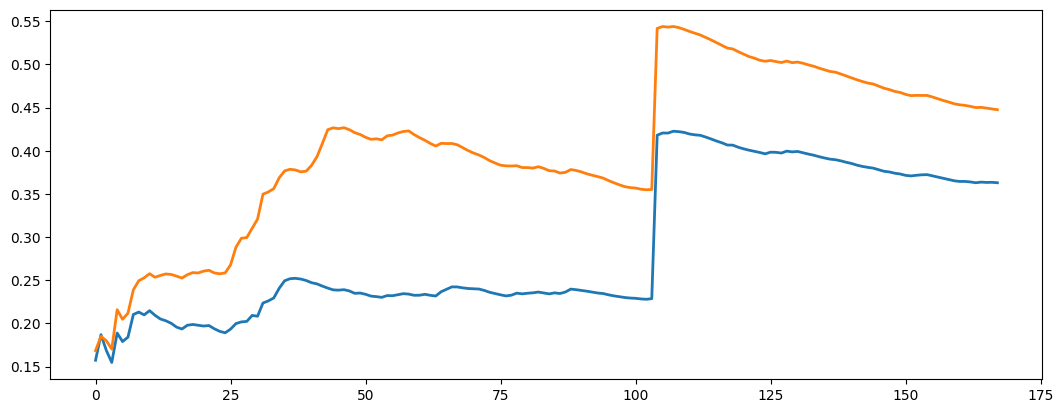

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12.8, 4.8))
plt.plot(mses[0], label='GroundTruth', linewidth=2)
plt.plot(mses_offline[0], label='GroundTruth', linewidth=2)
plt.show()

In [14]:
true = trues[:,:,:,:].reshape(-1)
pred_mimo = preds[:,:,:,:].reshape(-1)
# pred_onenet = preds_onenet[0,0]
print(true.shape, pred_mimo.shape)

mse = 0
for i in range(len(true)):
    mse += (true[i] - pred_mimo[i])**2
mse = mse / len(true)
print(mse)

(70560,) (70560,)
0.36295420305918946


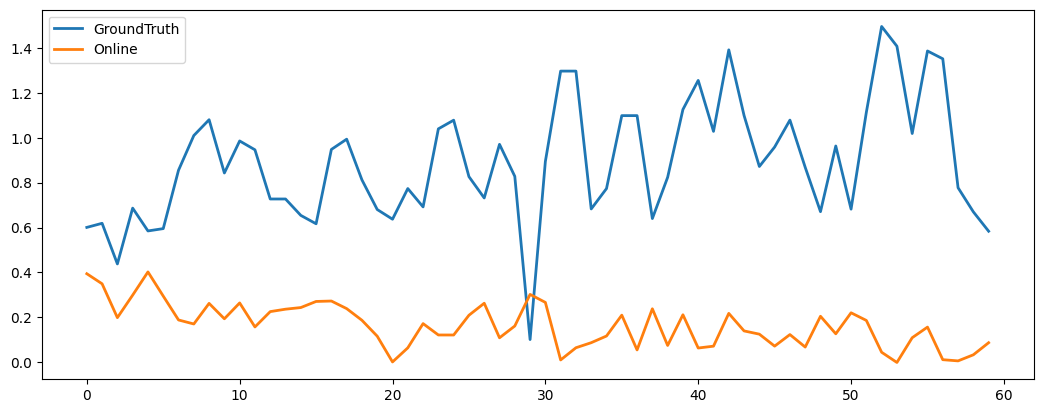

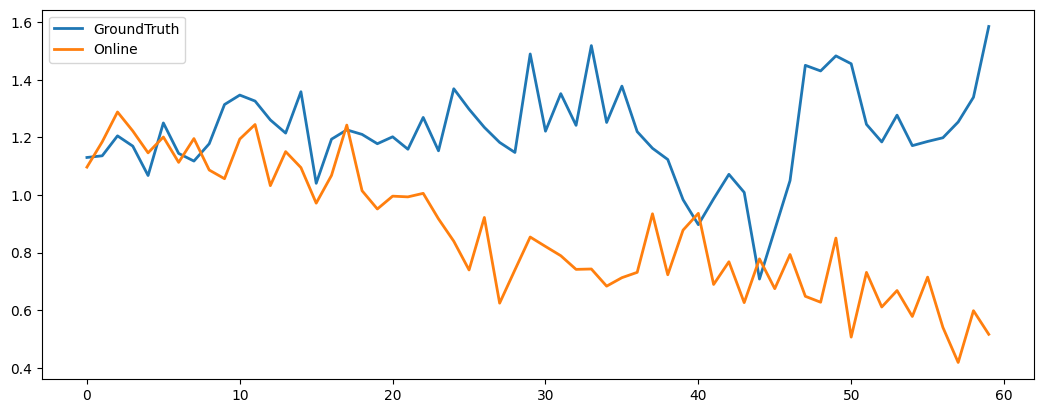

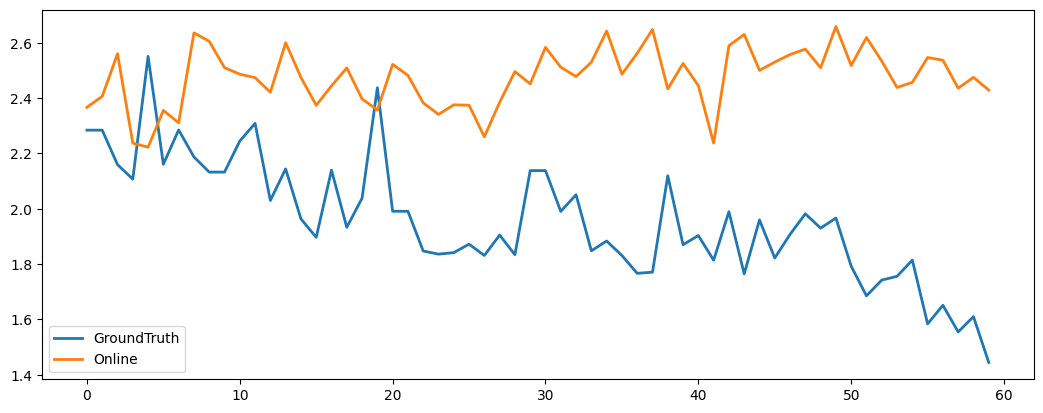

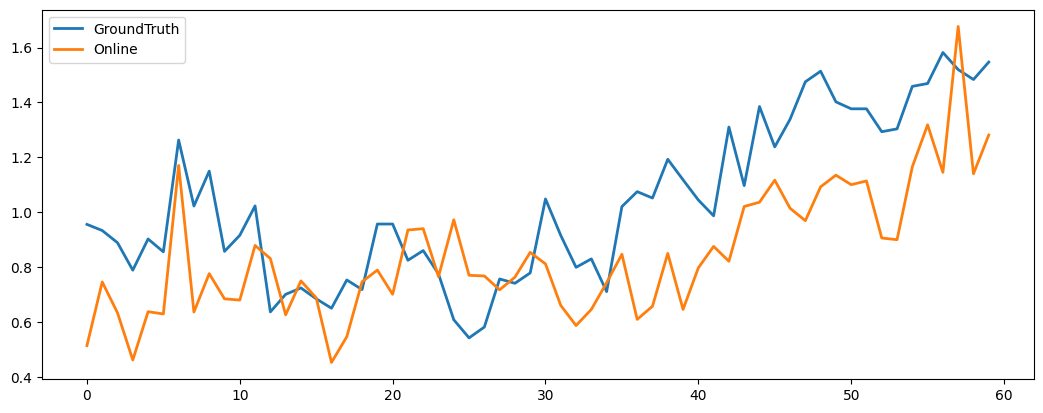

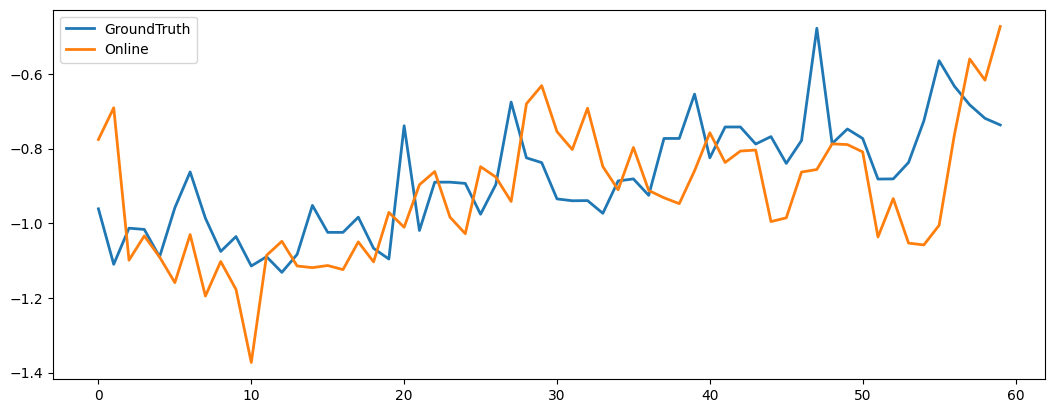

In [34]:
for i in range(preds.shape[1]):
    if i % 20 == 0 and i < 100:
        pred = preds[0,i,:,6]
        true = trues[0,i,:,6]
        # pred_fix = preds_onenet[0,i,:,1]
        visual(true, pred, pred_fix=None, name=f"./test_results/{i}.pdf",)
        

In [18]:
def FFT_for_Period(x, k=2):
    # [B, T, C]
    xf = torch.fft.rfft(x, dim=1)
    # find period by amplitudes
    frequency_list = abs(xf).mean(0).mean(-1)
    frequency_list[0] = 0
    _, top_list = torch.topk(frequency_list, k)
    top_list = top_list.detach().cpu().numpy()
    period = x.shape[1] // top_list
    return period, abs(xf).mean(-1)[:, top_list]

In [38]:
preds = []
trues = []
pred_fix = []
upper_bounds = []
lower_bounds = []
total_err = 0
total_upper_err = 0
period = 60
res_group = [[] for _ in range(period)]
alpha, alpha_t, gamma = 0.1, [0.1]*period, 0.05
folder_path = './test_results/' + setting + '/'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

exp.model.eval()
test_data, test_loader = exp._get_data(flag='test')

with torch.no_grad():
    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):

        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float().to(exp.device)

        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        # decoder input
        dec_inp = torch.zeros_like(batch_y[:, -exp.args.pred_len:, :]).float()
        dec_inp = torch.cat([batch_y[:, :exp.args.label_len, :], dec_inp], dim=1).float().to(exp.device)
        
        # encoder - decoder
        if exp.args.use_amp:
            with torch.cuda.amp.autocast():
                if exp.args.output_attention:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        else:
            if exp.args.output_attention:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]

            else:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

        f_dim = -1 if exp.args.features == 'MS' else 0
        outputs = outputs[:, -exp.args.pred_len:, :]
        batch_y = batch_y[:, -exp.args.pred_len:, :].to(exp.device)
        outputs = outputs.detach().cpu().numpy()
        batch_y = batch_y.detach().cpu().numpy()
        if test_data.scale and exp.args.inverse:
            shape = outputs.shape
            outputs = test_data.inverse_transform(outputs.squeeze(0)).reshape(shape)
            batch_y = test_data.inverse_transform(batch_y.squeeze(0)).reshape(shape)

        outputs = outputs[:, :, f_dim:]
        batch_y = batch_y[:, :, f_dim:]

        pred = outputs
        true = batch_y

        adjustment = true[:,0,:] - pred[:,0,:]
        adjusted_group_pred = pred + adjustment

        preds.append(pred)
        trues.append(true)
        pred_fix.append(adjusted_group_pred)

        
        # adjusted_predictions = np.array([[[]]])

        # for j in range(1440//period):  # 共12组
        #     start_idx = j * period  # 计算每组的起始索引
        #     end_idx = start_idx + period  # 计算每组的结束索引
        #     group_pred = pred[:,start_idx:end_idx,:]  # 获取当前组的预测值
        #     adjustment = true[:,j * period,:] - group_pred[:,0,:]  # 计算调整量，即真实值-当前组预测值的第一个点
        #     adjusted_group_pred = group_pred + adjustment  # 进行调整
        #     if j == 0:
        #         adjusted_predictions = adjusted_group_pred
        #     else:
        #         adjusted_predictions = np.concatenate((adjusted_predictions, adjusted_group_pred), axis=1)

            # adjusted_predictions.extend(adjusted_group_pred)  # 将调整后的预测值添加到结果列表中

        # 将调整后的预测值转换为numpy数组
        # adjusted_predictions = torch.tensor(np.array(adjusted_predictions)).detach().cpu().numpy()
        # pred_fix.append(adjusted_predictions)
        # pred_lower, pred_upper = [], []
        
        # for j in range(1440):        
        #     if i == 0:
        #         res_group[j%period].append(adjusted_predictions[0,j,0] - true[0,j,0])
        #     else:
        #         res_group_acp = np.abs(res_group[j%period])
        #         if(alpha_t[j%period] >= 1):
        #             alpha_t[j%period] = 1
        #         elif(alpha_t[j%period] <= 0):
        #             alpha_t[j%period] = 0 
        #         window = np.quantile(res_group_acp,(1-alpha_t[j%period]))
        #         y_lower_i, y_upper_i = adjusted_predictions[0,j,0]-window, adjusted_predictions[0,j,0]+window
        #         err = 1-float((y_lower_i <= true[0,j,0]) & (true[0,j,0] <= y_upper_i))
        #         upper_err = 1 - float((true[0,j,0] <= y_upper_i))
        #         total_err += err
        #         total_upper_err += upper_err
        #         alpha_t[j%period] = alpha_t[j%period] + gamma*(alpha-err)
        #         pred_lower.append(y_lower_i)
        #         pred_upper.append(y_upper_i)
        #         res_group[j%period].append(adjusted_predictions[0,j,0] - true[0,j,0])
        # lower_bounds.append(np.array(pred_lower).reshape(1,-1,1))
        # upper_bounds.append(np.array(pred_upper).reshape(1,-1,1))

        # print(total_err)

        if i % 20 == 1:
            input = batch_x.detach().cpu().numpy()
            if test_data.scale and exp.args.inverse:
                shape = input.shape
                input = test_data.inverse_transform(input.squeeze(0)).reshape(shape)
            # gt = np.concatenate((input[0, :, -1], true[0, :, -1]), axis=0)
            # pd = np.concatenate((input[0, :, -1], pred[0, :, -1]), axis=0)
            gt = true[0, :, -1]
            pd = pred[0, :, -1]
            adjusted_group_pred = adjusted_group_pred[0, :, -1]
            # pd_fix = adjusted_predictions[0,:,-1]

            visual(gt, pd,pred_fix=adjusted_group_pred, name = os.path.join(folder_path, str(i) + '_fix.pdf'))
        

preds = np.array(preds)
trues = np.array(trues)
pred_fix = np.array(pred_fix)

print('test shape:', preds.shape, pred_fix.shape, trues.shape)
preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
pred_fix = pred_fix.reshape(-1, pred_fix.shape[-2], pred_fix.shape[-1])
print('test shape:', preds.shape, trues.shape)

# result save
folder_path = './results/' + setting + '/'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

mae, mse, rmse, mape, mspe = metric(preds, trues)
mae_fix, mse_fix, rmse_fix, mape_fix, mspe_fix = metric(pred_fix, trues)
print('mse:{}, mae:{}'.format(mse, mae))
print('mse_fix:{}, mae_fix:{}'.format(mse_fix, mae_fix))
print('total coerage rate:', 1 - total_err/1440/4)
print('total upper bound err: ', 1 - total_upper_err/1440/4)
f = open("result_long_term_forecast.txt", 'a')
f.write(setting + "  \n")
f.write('mse:{}, mae:{}'.format(mse, mae))
f.write('\n')
f.write('\n')
f.close()

test 145
test shape: (145, 1, 1440, 1) (145, 1, 1440, 1) (145, 1, 1440, 1)
test shape: (145, 1440, 1) (145, 1440, 1)
mse:0.43083176016807556, mae:0.452509343624115
mse_fix:0.452480286359787, mae_fix:0.4685702919960022
total coerage rate: 1.0
total upper bound err:  1.0


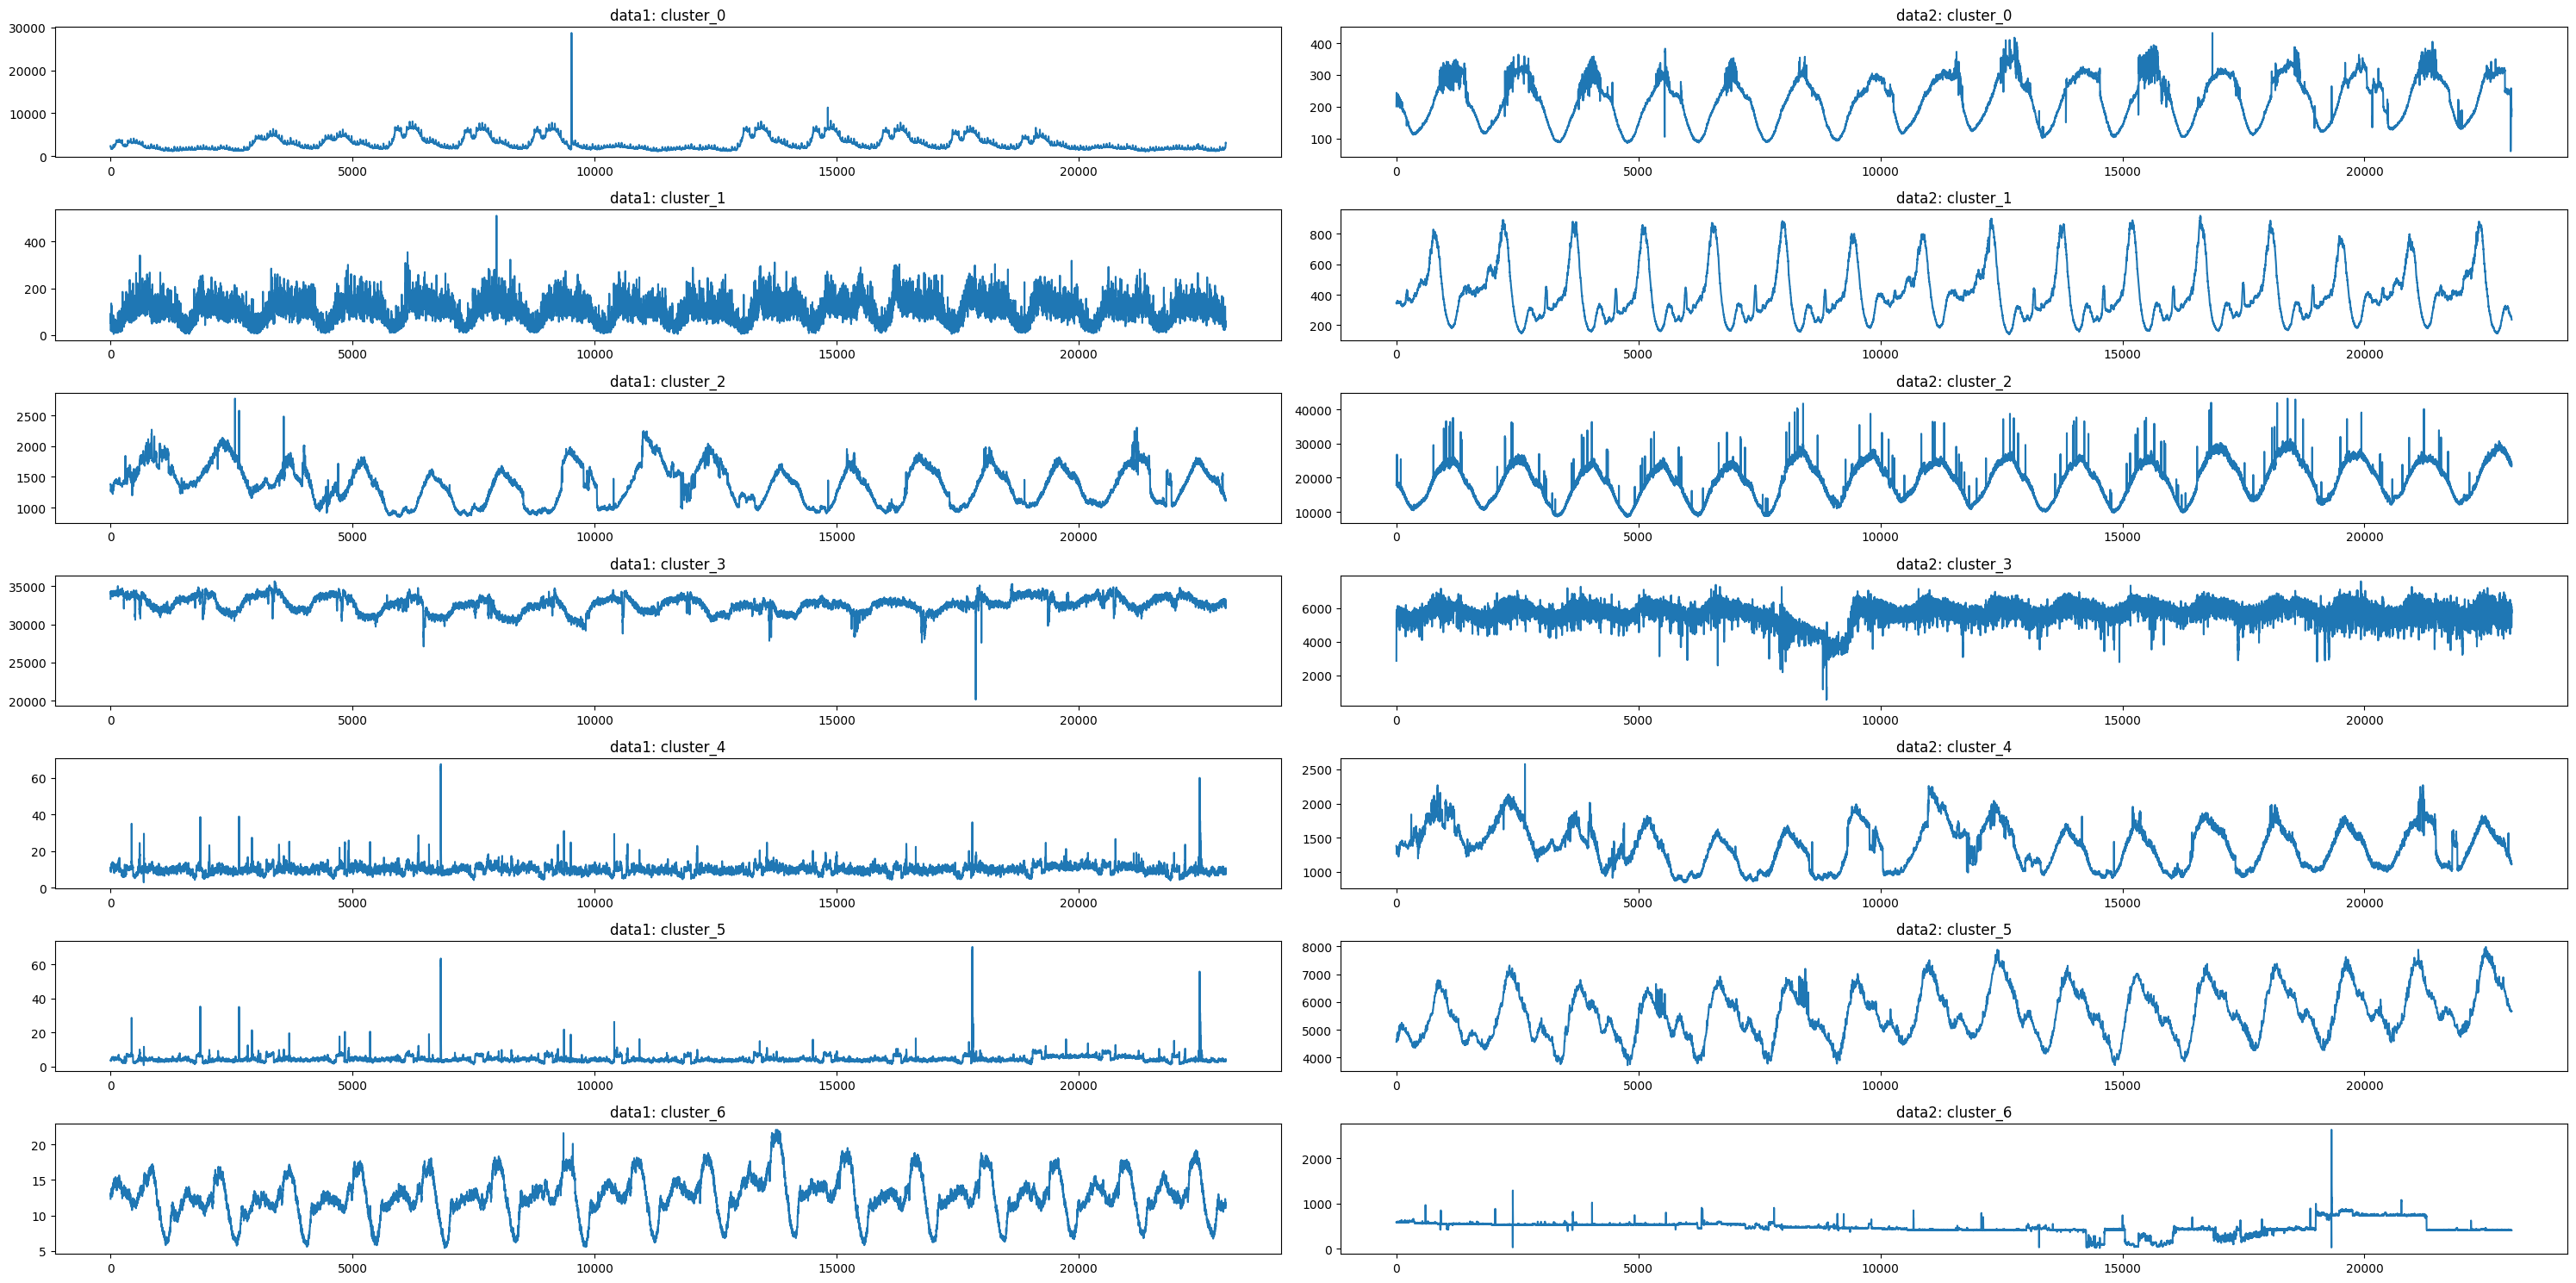

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取两个CSV文件，忽略'date'列
data1 = pd.read_csv('./data/FaaS_small.csv').drop(columns=['date'])
data2 = pd.read_csv('./data/FaaS_small_transfer.csv').drop(columns=['date'])

# 确保图形尺寸足够大以容纳所有子图
plt.figure(figsize=(30, 15))

# 对于data1和data2中的每一列
for i, column in enumerate(data1.columns):
    # 第一列的子图（对应data1）
    plt.subplot(7, 2, 2*i + 1)
    plt.plot(data1[column])
    plt.title(f'data1: {column}')
    plt.tight_layout()

    # 第二列的子图（对应data2）
    plt.subplot(7, 2, 2*i + 2)
    plt.plot(data2[column])
    plt.title(f'data2: {column}')
    plt.tight_layout()

# 显示图形
plt.show()

In [13]:
# import torch 
import numpy as np
# onenet_file = "/mnt/bn/jiadong2/Online_results/onenet_fsnet_FaaS_medium_1440_pl60_olfull_optadam_tb1_2024_07_08_21_45_1f34/"
# mimo_file = "/mnt/bn/jiadong2/Online_results/mimo_patchv1_case_study_1440_pl60_olfull_optadam_tb1_2024_07_26_16_17_86de/"
onenet = "/mnt/bn/jiadong2/Online_results/fsnet_time_case_study_1440_pl60_olfull_optadam_tb1_2024_07_26_16_23_c31c/"
# mimo_greedy_file = "/mnt/bn/jiadong2/Online_results/mimo_patch_FaaS_small_1440_pl60_olfull_optadam_tb1_2024_07_09_16_46_91d2/"
# preds = np.load(mimo_file + f"preds.npy")
# trues = np.load(mimo_file + f"trues.npy")
# mses = np.load(mimo_file + f"mse.npy")
# mses_onenet= np.load(onenet + f"mse.npy")
preds_onenet = np.load(onenet + f"preds.npy")
# preds_onenet = np.load(mimo_greedy_file + f"preds.npy")
# pred_fixs = np.load(f'./test_results/pred_fix.npy')
preds_onenet.shape#,preds_onenet.shape # preds_onenet.shape

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# preds_onenet_1d_1d = preds_onenet_1d[:24*60]

plt.figure(figsize=(15,5))
plt.plot(trues[0,1,::7], label='GroundTruth', linewidth=2, color='black')
plt.plot(preds_onenet[0,1,::7], label='Forecasting', linewidth=2, color='blue')

# plt.plot
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/bn/jiadong2/Online_results/fsnet_time_case_study_1440_pl60_olfull_optadam_tb1_2024_07_26_16_23_c31c/preds.npy'

In [17]:
import torch
import statsmodels.api
import numpy as np

class ETS:
    def __init__(self, trend=None, damped_trend=False,
                 seasonal=None, seasonal_periods=None, initialization_method='estimated', horizon=60):
        '''
        指数平滑模型，接口来自statsmodels
        详情参考：
        https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.fit.html#statsmodels.tsa.holtwinters.ExponentialSmoothing.fit
        https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html
        '''
        self.trend = trend
        self.damped_trend = damped_trend
        self.seasonal = seasonal
        self.seasonal_periods = seasonal_periods
        self.initialization_method = initialization_method
        self.model = None
        self.training_res = None
        self.horizon = horizon
        self.predictions = None
        
    def fit_predict(self, x):
        b, t, d = x.shape
        x = x.numpy()
        for i in range(b):  
            channels = []
            for j in range(d):
                model = statsmodels.tsa.holtwinters.ExponentialSmoothing(x[i,:,j], trend = self.trend,
                                                            damped_trend = self.damped_trend,
                                                            seasonal = self.seasonal,
                                                            seasonal_periods = self.seasonal_periods,
                                                    initialization_method = self.initialization_method)
                training_model = model.fit()
                channels.append(training_model.forecast(steps=self.horizon))
            if self.predictions is None:
                self.predictions = np.array(channels).reshape(1,self.horizon,d)
            else:
                self.predictions = np.concatenate((self.predictions, np.array(channels).reshape(1,self.horizon,d)), axis=0)
        self.predictions = torch.from_numpy(self.predictions).cuda()
        return self.predictions
    


x = torch.randn(1, 1440, 7)

model = ETS(trend='add', damped_trend=True, seasonal='add', seasonal_periods=60, initialization_method='estimated', horizon=60)
pred = model.fit_predict(x)
print(pred.shape)

/root/anaconda3/envs/TSlib/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [9]:
import torch
import pmdarima as pm
import numpy as np
import statsmodels.api
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast

class ETS:
    def __init__(self, trend=None, damped_trend=False,
                 seasonal=None, seasonal_periods=None, initialization_method='estimated', horizon=60):
        '''
        指数平滑模型，接口来自statsmodels
        详情参考：
        https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.fit.html#statsmodels.tsa.holtwinters.ExponentialSmoothing.fit
        https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html
        '''
        self.trend = trend
        self.damped_trend = damped_trend
        self.seasonal = seasonal
        self.seasonal_periods = seasonal_periods
        self.initialization_method = initialization_method
        self.model = None
        self.training_res = None
        self.horizon = horizon
        self.predictions = None
        
    def fit_predict(self, x):
        b, t, d = x.shape
        x = x.numpy()
        for i in range(b):  
            channels = []
            for j in range(d):
                # stlf = STLForecast(elec_equip, ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"))
                model = STLForecast(x[i,:,j], ARIMA, period=60, model_kwargs=dict(order=(1, 1, 0), trend="t"))

                # model = pm.auto_arima(x[i,:,j], seasonal=True, m=60, stepwise=True, suppress_warnings=True)
                training_model = model.fit()
                # forecast, conf_int = model.predict(n_periods=60, return_conf_int=True)
                channels.append(training_model.forecast(steps=self.horizon))
                # channels.append(forecast)
            if self.predictions is None:
                self.predictions = np.array(channels).reshape(1,self.horizon,d)
            else:
                self.predictions = np.concatenate((self.predictions, np.array(channels).reshape(1,self.horizon,d)), axis=0)
        # self.predictions = torch.from_numpy(self.predictions).cuda()
        return self.predictions
    


x = torch.randn(1, 1440, 7)

model = ETS(horizon=60)
pred = model.fit_predict(x)
print(pred.shape)

(1, 60, 7)


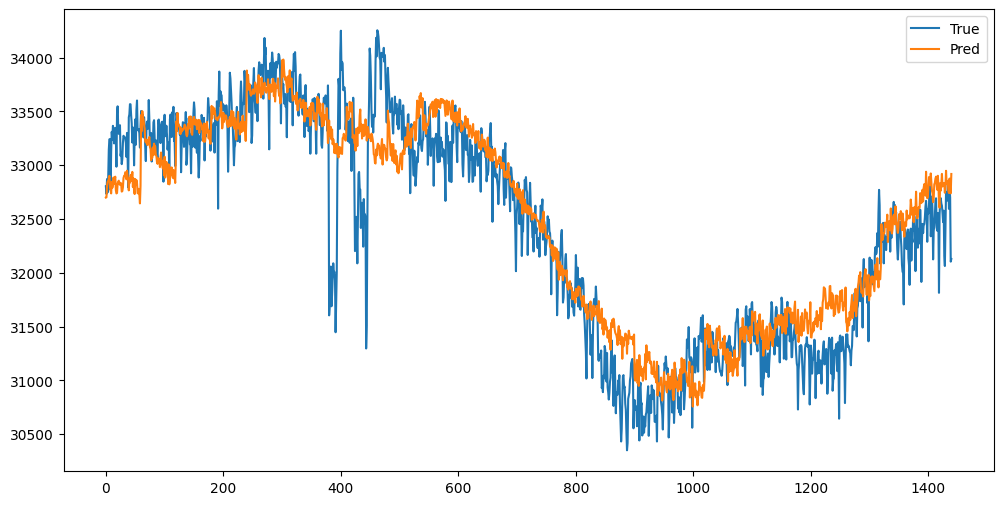

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data1 = pd.read_csv('./data/FaaS_small.csv').drop(columns=['date'])
tures_1d = data1['cluster_0'].values[10080+1440:20160+1440]
preds = np.load('/mnt/bn/jiadong2/Online_results/preds_reverse.npy')
trues_reverse = np.load('/mnt/bn/jiadong2/Online_results/tures_reverse.npy')
preds_1d = preds[:,:,3].reshape(-1)
trues_reverse_1d = trues_reverse[:,:,3].reshape(-1)
plt.figure(figsize=(12, 6))
plt.plot(trues_reverse_1d[:1440], label='True')
plt.plot(preds_1d[:1440], label='Pred')
plt.legend()
plt.show()


In [53]:
wmape = 0
for i in range(len(tures_1d)):
    wmape += abs(preds_1d[i] - trues_reverse_1d[i])
wmape /= sum(trues_reverse_1d)
print(wmape)

0.011777817404218951


In [39]:
preds_1d = preds[:,:,0].reshape(-1)
trues_reverse_1d = trues_reverse[:,:,0].reshape(-1)

wmape_reverse = np.sum(np.abs(preds-trues_reverse)) / np.sum(trues_reverse)
wmape_reverse


0.0190984

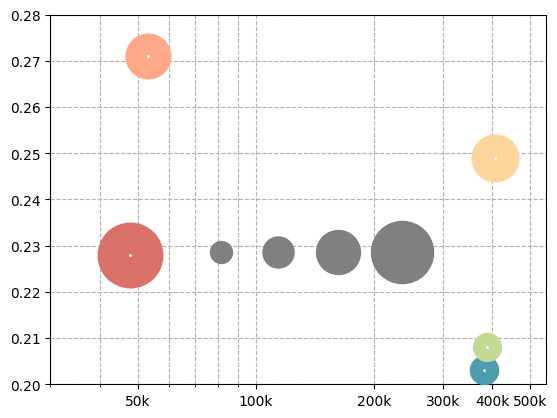

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import math


# 假设你的模型数据是这样的
models = {
    'E$^3$Former-OS': {'throughput': 380844.376 , 'accuracy': 0.203 , 'param_size': (412324.000), "color": "#4C9DAE" }, 
    'E$^3$Former-FTPL': {'throughput': 387613.106 , 'accuracy': 0.208 , 'param_size': 401478.000, "color": "#C5D893" },
    'OneNet': {'throughput': 47947.859 , 'accuracy': 0.228 , 'param_size': 2160996.000, "color": "#D97069" },
    'FSNet': {'throughput': 53070.138  , 'accuracy': 0.271 , 'param_size': 1034674.000, "color": "#FFA889" },
    'Time-FSNet': {'throughput': 406733.123  , 'accuracy': 0.249 , 'param_size': 1126322.000, "color": "#FBD59C" },
    # 'GPT4TS': {'throughput': 32091.120  , 'accuracy': 0.253 , 'param_size': 15},
    # 添加更多模型...
}

# 创建图形和轴
fig, ax = plt.subplots()
plt.grid(True, which="both", ls="--", zorder=0)  # 添加网格线，对数尺度时特别有用

# plt.figure(figsize=(12, 6))


# 确定图例中表示的参数量大小点
sizes = [250000, 500000, 1000000, 2000000]  # 举例说明
size_str = ["25k", "50k", '100k', "200k"]
label = [" ", "  ", "   ", "    "]
for i, size in enumerate(sizes):
    ax.scatter([], [], s=size/1000, color='gray', label=label[i])

# 画出所有模型的点
for model, info in models.items():
    x = info['throughput']
    y = info['accuracy']
    size = info['param_size'] / 1000
    ax.scatter(x, y, s=size, color=info['color'],zorder=3)
    ax.scatter(x, y, s=1, color='white',zorder=3)

# ax.set_xlabel('Throughout (QPS)', fontsize=18)
# ax.set_ylabel('MSE', fontsize=18)

# plt.gca().invert_yaxis()
plt.xscale('log')
# plt.gca().xaxis.set_major_locator(ticker.FixedLocator([1, 50000, 150000, 250000, 350000, 450000, 500000]))
# plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1000)}k'))


# 控制图例的位置
# legend = plt.legend(title='点大小表示: ', loc='upper left')
legend = plt.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.55, 0.4), fontsize=8, frameon=False)
# plt.legend(frameon=False)
plt.xticks([50000, 100000, 200000, 300000, 400000, 500000], 
           ['50k', '100k', '200k', '300k', '400k', '500k'])

plt.ylim(0.20, 0.28)
plt.xlim(30000, 550000)
# 添加虚线边框，首先我们将 fancybox 设置为 False 来取消圆滑边框
legend.get_frame().set_edgecolor('black')  # 设置边框颜色为黑色
legend.get_frame().set_linewidth(1)        # 设置边框宽度
# 以下是设置虚线边框的正确方法，但请注意，这可能在不同版本的matplotlib中表现不同
legend.get_frame().set_linestyle((0, (5, 10)))  # 设置虚线样式

# plt.title('FaaS')
plt.savefig(f'./figures/throughout.pdf', format='pdf')
plt.show()
